In [246]:
import pandas as pd
import matplotlib.pyplot as plt

In [247]:
trips = pd.read_csv("data/201812-fordgobike-tripdata.csv")
weather = pd.read_csv('data/weather.csv')

In [255]:
def feature_addition(df):
    '''
    INPUT dataframe
    OUTPUT dataframe with extra features
    '''
    #create a new column that shows the day of week for each trip
    #need to transform panda series to datetime
    #before we can use .dt.dayofweek
    #monday = 0 and sunday = 6

    df.start_time = pd.to_datetime(df.start_time)
    df['trip_date'] = df.start_time.dt.date
    df['quarter'] = df.start_time.dt.quarter
    df['day_of_week'] = df.start_time.dt.dayofweek
    df['hour'] = df.start_time.dt.hour

    #any trip with less than 90 seconds and where
    #start station IS the end station,
    #we make the assumption that its malfunctioned
    df['malfunction'] = (df.duration_sec < 90) & (df.start_station_name == df.end_station_name)
    df['age'] = 2019 - df.member_birth_year
    return df

def num_malfunctions(df):
    '''
    INPUT: Dataframe with a "malfunction" column
    Sum the number of malfunctions up
    OUTPUT: Tuple with 
            first element as number of malfunctions and
            second element as number of non-malfunctions
    '''

    num_malfunctions = df.malfunction.sum()
    num_working = len(df.malfunction) - num_malfunctions

    return (num_malfunctions, num_working)

def frequent_malfunction(df):
    return df.bike_id[df.malfunction == True].value_counts()

def model_city(df, city = 1):
    if city == 1:
        return df[(df.start_station_latitude > 37.697799) & (df.start_station_longitude <-122.330676)]
    elif city == 2:
        return df[(df.start_station_latitude > 37.697799) & (df.start_station_longitude >-122.330676)]
    elif city == 3:
        return df[df.start_station_latitude < 37.697799]


In [256]:
df = feature_addition(trips)

In [257]:
num_malfunctions(df)

(218, 131145)

In [258]:
sf = model_city(df,1)
sf.head(5)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,user_type,member_birth_year,member_gender,bike_share_for_all_trip,trip_date,quarter,day_of_week,hour,malfunction,age
3,30550,2018-12-31 19:26:20.775,2019-01-01 03:55:30.7930,13.0,Commercial St at Montgomery St,37.794231,-122.402923,19.0,Post St at Kearny St,37.788975,...,Subscriber,1986.0,Male,Yes,2018-12-31,4,0,19,False,33.0
4,2150,2018-12-31 23:59:12.097,2019-01-01 00:35:02.1530,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,368.0,Myrtle St at Polk St,37.785434,...,Customer,NaN,NaN,No,2018-12-31,4,0,23,False,NaN
5,2149,2018-12-31 23:59:11.882,2019-01-01 00:35:01.6850,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,368.0,Myrtle St at Polk St,37.785434,...,Subscriber,1982.0,Male,Yes,2018-12-31,4,0,23,False,37.0
6,2502,2018-12-31 23:46:24.943,2019-01-01 00:28:07.3560,67.0,San Francisco Caltrain Station 2 (Townsend St...,37.776639,-122.395526,44.0,Civic Center/UN Plaza BART Station (Market St ...,37.781074,...,Customer,1973.0,Male,No,2018-12-31,4,0,23,False,46.0
7,8202,2018-12-31 22:11:22.506,2019-01-01 00:28:05.1730,324.0,Union Square (Powell St at Post St),37.788300,-122.408531,16.0,Steuart St at Market St,37.794130,...,Customer,1995.0,Male,No,2018-12-31,4,0,22,False,24.0


In [254]:
oak = model_city(df, 2)
sj = model_city(df,3)

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([2.3834e+04, 3.9957e+04, 1.7026e+04, 8.6710e+03, 2.5090e+03,
        4.2900e+02, 1.3800e+02, 0.0000e+00, 1.0000e+00, 1.6000e+01]),
 array([ 19.,  29.,  39.,  49.,  59.,  69.,  79.,  89.,  99., 109., 119.]),
 <a list of 10 Patch objects>)

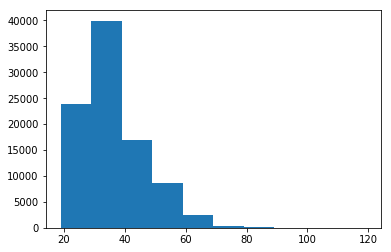

In [263]:
plt.hist(sf.age)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,trip_date,quarter,day_of_week,hour,malfunction
start_time,,,,,,,,,,,,,,,,,,,,,
2018-12-31 20:03:11.735,68529,2018-12-31 20:03:11.735,2019-01-01 15:05:21.5580,217.0,27th St at MLK Jr Way,37.817015,-122.271761,217.0,27th St at MLK Jr Way,37.817015,...,3305,Customer,NaN,NaN,No,2018-12-31,4,0,20,False
2018-12-31 19:00:32.121,63587,2018-12-31 19:00:32.121,2019-01-01 12:40:19.3660,NaN,NaN,37.400000,-121.940000,NaN,NaN,37.400000,...,4281,Customer,1995.0,Male,No,2018-12-31,4,0,19,False
2018-12-31 15:09:01.082,64169,2018-12-31 15:09:01.082,2019-01-01 08:58:30.0910,NaN,NaN,37.400000,-121.940000,NaN,NaN,37.400000,...,4267,Customer,1988.0,Male,No,2018-12-31,4,0,15,False
2018-12-31 19:26:20.775,30550,2018-12-31 19:26:20.775,2019-01-01 03:55:30.7930,13.0,Commercial St at Montgomery St,37.794231,-122.402923,19.0,Post St at Kearny St,37.788975,...,5422,Subscriber,1986.0,Male,Yes,2018-12-31,4,0,19,False
2018-12-31 23:59:12.097,2150,2018-12-31 23:59:12.097,2019-01-01 00:35:02.1530,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,368.0,Myrtle St at Polk St,37.785434,...,4820,Customer,NaN,NaN,No,2018-12-31,4,0,23,False
2018-12-31 23:59:11.882,2149,2018-12-31 23:59:11.882,2019-01-01 00:35:01.6850,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,368.0,Myrtle St at Polk St,37.785434,...,5549,Subscriber,1982.0,Male,Yes,2018-12-31,4,0,23,False
2018-12-31 23:46:24.943,2502,2018-12-31 23:46:24.943,2019-01-01 00:28:07.3560,67.0,San Francisco Caltrain Station 2 (Townsend St...,37.776639,-122.395526,44.0,Civic Center/UN Plaza BART Station (Market St ...,37.781074,...,4706,Customer,1973.0,Male,No,2018-12-31,4,0,23,False
2018-12-31 22:11:22.506,8202,2018-12-31 22:11:22.506,2019-01-01 00:28:05.1730,324.0,Union Square (Powell St at Post St),37.788300,-122.408531,16.0,Steuart St at Market St,37.794130,...,5518,Customer,1995.0,Male,No,2018-12-31,4,0,22,False
2018-12-31 23:47:19.210,2170,2018-12-31 23:47:19.210,2019-01-01 00:23:30.1300,6.0,The Embarcadero at Sansome St,37.804770,-122.403234,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,...,4800,Customer,1999.0,Female,No,2018-12-31,4,0,23,False


(1888.0, 2000.0)

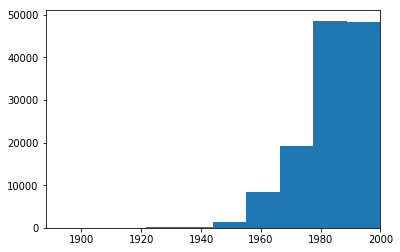

In [61]:

plt.hist(df.member_birth_year[df.member_birth_year.notna()])
plt.xlim(df.member_birth_year.min(), df.member_birth_year.max())

In [64]:
#there are roughly 1672 people who were born before 1940
#consider deleting these since they're 70+ years old
df.member_birth_year[df.member_birth_year<1940].count

<bound method Series.count of 1672      1900.0
4228      1900.0
4579      1900.0
4999      1900.0
6047      1900.0
6066      1900.0
6409      1900.0
9490      1900.0
9538      1900.0
10190     1932.0
10289     1932.0
13666     1938.0
13718     1938.0
13881     1900.0
14407     1938.0
14656     1938.0
16173     1900.0
16433     1888.0
17035     1933.0
17412     1900.0
18851     1931.0
20384     1933.0
20414     1933.0
22142     1900.0
22635     1900.0
23060     1939.0
23141     1939.0
23634     1900.0
24554     1903.0
24685     1900.0
           ...  
116010    1931.0
116085    1931.0
116134    1931.0
116193    1931.0
116260    1931.0
116347    1931.0
116439    1931.0
116490    1931.0
116539    1931.0
116602    1931.0
116663    1931.0
116705    1931.0
116734    1931.0
116759    1931.0
116822    1931.0
116851    1931.0
116884    1931.0
116907    1931.0
116960    1931.0
116981    1931.0
116998    1931.0
123527    1933.0
126776    1932.0
126781    1900.0
126878    1932.0
126889    1900.0
1

In [22]:

trips['malfunction'] = (trips.duration_sec < 90) & (trips.start_station_name == trips.end_station_name)


In [23]:
trips.head(5)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,day_of_week,trip_date,malfunction
0,68529,2018-12-31 20:03:11.735,2019-01-01 15:05:21.5580,217.0,27th St at MLK Jr Way,37.817015,-122.271761,217.0,27th St at MLK Jr Way,37.817015,-122.271761,3305,Customer,NaN,NaN,No,0,2018-12-31,False
1,63587,2018-12-31 19:00:32.121,2019-01-01 12:40:19.3660,NaN,NaN,37.400000,-121.940000,NaN,NaN,37.400000,-121.940000,4281,Customer,1995.0,Male,No,0,2018-12-31,False
2,64169,2018-12-31 15:09:01.082,2019-01-01 08:58:30.0910,NaN,NaN,37.400000,-121.940000,NaN,NaN,37.400000,-121.940000,4267,Customer,1988.0,Male,No,0,2018-12-31,False
3,30550,2018-12-31 19:26:20.775,2019-01-01 03:55:30.7930,13.0,Commercial St at Montgomery St,37.794231,-122.402923,19.0,Post St at Kearny St,37.788975,-122.403452,5422,Subscriber,1986.0,Male,Yes,0,2018-12-31,False
4,2150,2018-12-31 23:59:12.097,2019-01-01 00:35:02.1530,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,368.0,Myrtle St at Polk St,37.785434,-122.419622,4820,Customer,NaN,NaN,No,0,2018-12-31,False


In [16]:
plt.plot(df.day_of_week)

0          True
1         False
2         False
3         False
4         False
5         False
6         False
7         False
8         False
9         False
10        False
11        False
12         True
13        False
14        False
15        False
16        False
17        False
18        False
19        False
20        False
21        False
22        False
23        False
24        False
25        False
26        False
27         True
28        False
29        False
          ...  
131333    False
131334    False
131335    False
131336    False
131337    False
131338    False
131339    False
131340    False
131341    False
131342    False
131343    False
131344    False
131345    False
131346    False
131347    False
131348    False
131349    False
131350    False
131351    False
131352    False
131353    False
131354    False
131355    False
131356    False
131357    False
131358    False
131359    False
131360    False
131361    False
131362    False
Length: 131363, dtype: b

In [26]:
weather.tail(5)

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,PRCP_ATTRIBUTES,SNOW,SNOW_ATTRIBUTES,SNWD,SNWD_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES
787,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",37.7705,-122.4269,45.7,2019-02-28,0.00,",,W,2400",0.0,",,W",0.0,",,W",NaN,NaN,56,",,W",49,",,W"
788,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",37.7705,-122.4269,45.7,2019-03-01,0.01,",,W,2400",0.0,",,W",0.0,",,W",NaN,NaN,57,",,W",47,",,W"
789,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",37.7705,-122.4269,45.7,2019-03-02,0.81,",,W,2400",0.0,",,W",0.0,",,W",NaN,NaN,56,",,W",50,",,W"
790,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",37.7705,-122.4269,45.7,2019-03-03,0.07,",,W,2400",0.0,",,W",0.0,",,W",NaN,NaN,57,",,W",50,",,W"
791,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",37.7705,-122.4269,45.7,2019-03-04,0.11,",,W,2400",0.0,",,W",0.0,",,W",NaN,NaN,56,",,W",49,",,W"


MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False